In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata

# Preprocess the data

path_data = '../../Datasets/VAERS/2021VAERSDATA.csv'
path_vax = '../../Datasets/VAERS/2021VAERSVAX.csv'

df_data = pd.read_csv(path_data, dtype='unicode')
df_vax = pd.read_csv(path_vax, dtype='unicode')

df_vax = df_vax[['VAX_MANU', 'VAX_DOSE_SERIES']].copy()
df = df_data[['AGE_YRS', 'SEX']].copy()
df = pd.concat([df,df_vax], axis=1, join="inner")

# Target variables: Died, Life Threatening, Hospitalized, Disabled, Recovered
df_outcomes = df_data[['DIED', 'L_THREAT', 'HOSPITAL', 'DISABLE', 'RECOVD']].copy()
df = pd.concat([df,df_outcomes], axis=1, join="inner")

print(df.head())
print(df.info())

  AGE_YRS SEX         VAX_MANU VAX_DOSE_SERIES DIED L_THREAT HOSPITAL DISABLE  \
0    33.0   F          MODERNA               1  NaN      NaN      NaN     NaN   
1    73.0   F          MODERNA               1  NaN      NaN      NaN     NaN   
2    23.0   F  PFIZER\BIONTECH               1  NaN      NaN      NaN     NaN   
3    58.0   F          MODERNA             UNK  NaN      NaN      NaN     NaN   
4    47.0   F          MODERNA               1  NaN      NaN      NaN     NaN   

  RECOVD  
0      Y  
1      Y  
2      U  
3      Y  
4      N  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146622 entries, 0 to 146621
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   AGE_YRS          131782 non-null  object
 1   SEX              146622 non-null  object
 2   VAX_MANU         146622 non-null  object
 3   VAX_DOSE_SERIES  145639 non-null  object
 4   DIED             3731 non-null    object
 5   L_THREAT  

In [81]:
# Normalize and scale the data

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# AGE_YEARS
# Remove rows with missing values;
# Change data type to float
df.drop(df[df['AGE_YRS'].isna()].index, inplace = True)
df["AGE_YRS"] = df["AGE_YRS"].astype(str).astype(float)

# SEX
# Remove rows with blank cells
df.drop(df[df['SEX'].isna()].index, inplace = True)

# VAX_MANU
# Contains: 'DYNAVAX TECHNOLOGIES CORPORATION', 'EMERGENT BIOSOLUTIONS', 'GLAXOSMITHKLINE BIOLOGICALS', 'JANSSEN', 'MERCK & CO. INC.', 'MODERNA', 'NOVARTIS VACCINES AND DIAGNOSTICS', 'PFIZER\\BIONTECH', 'PFIZER\\WYETH', 'PROTEIN SCIENCES CORPORATION', 'SANOFI PASTEUR', 'SEQIRUS, INC.', 'TEVA PHARMACEUTICALS', 'UNKNOWN MANUFACTURER'

# VAX_DOSE_SERIES
# Remove rows where VAX_DOSE_SERIES is not 1 or 2
# Change data type
df.drop(df[(df['VAX_DOSE_SERIES']!="1") & (df['VAX_DOSE_SERIES']!="2")].index, inplace = True)
df["VAX_DOSE_SERIES"] = df["VAX_DOSE_SERIES"].astype(str).astype(int)

# RECOVD
# Remove rows where RECOVD is not 1 or 2
df.drop(df[(df['RECOVD']!="Y") & (df['RECOVD']!="N")].index, inplace = True)

# Update indeces
df = df.reset_index().copy()
del df['index']

# cleaned 44.2% of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81815 entries, 0 to 81814
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE_YRS          81815 non-null  float64
 1   SEX              81815 non-null  object 
 2   VAX_MANU         81815 non-null  object 
 3   VAX_DOSE_SERIES  81815 non-null  int64  
 4   DIED             2158 non-null   object 
 5   L_THREAT         1956 non-null   object 
 6   HOSPITAL         5277 non-null   object 
 7   DISABLE          1537 non-null   object 
 8   RECOVD           81815 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 5.6+ MB


In [82]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Scale or encode the values
encoder = LabelEncoder()
scaler = MinMaxScaler() 

# Encode: SEX(Male=1; Female=0); DIED(Y=0; NaN=1); L_THREAT(Y=0; NaN=1); HOSPITAL(Y=0; NaN=1); DISABLE(Y=0; NaN=1); RECOVD(Y=1; N=0); VAX_MENU(...)
df[["SEX"]] = encoder.fit_transform(np.ravel(df["SEX"]))
df[["VAX_MANU"]] = encoder.fit_transform(np.ravel(df["VAX_MANU"]))
df[["DIED"]] = encoder.fit_transform(np.ravel(df["DIED"]))
df[["L_THREAT"]] = encoder.fit_transform(np.ravel(df["L_THREAT"]))
df[["HOSPITAL"]] = encoder.fit_transform(np.ravel(df["HOSPITAL"]))
df[["DISABLE"]] = encoder.fit_transform(np.ravel(df["DISABLE"]))
df[["RECOVD"]] = encoder.fit_transform(np.ravel(df["RECOVD"]))

# Scale: AGE_YRS, VAX_MANU
df[["AGE_YRS", "VAX_MANU"]] = scaler.fit_transform(df[["AGE_YRS", "VAX_MANU"]])

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81815 entries, 0 to 81814
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE_YRS          81815 non-null  float64
 1   SEX              81815 non-null  int64  
 2   VAX_MANU         81815 non-null  float64
 3   VAX_DOSE_SERIES  81815 non-null  int64  
 4   DIED             81815 non-null  int64  
 5   L_THREAT         81815 non-null  int64  
 6   HOSPITAL         81815 non-null  int64  
 7   DISABLE          81815 non-null  int64  
 8   RECOVD           81815 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 5.6 MB


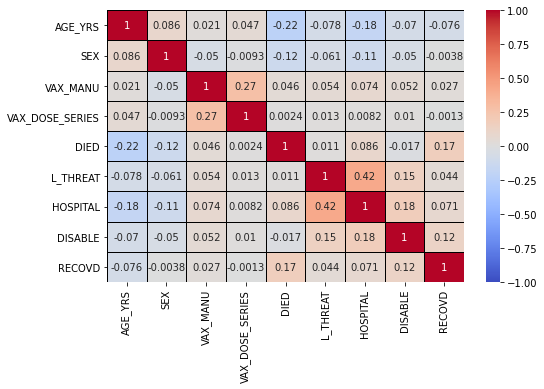

In [88]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,5))  
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1, linecolor='black')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


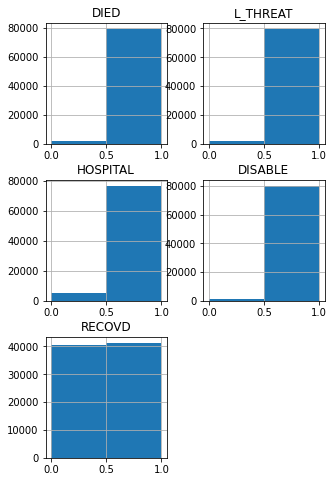

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statistics

X = df[['AGE_YRS', 'SEX', 'VAX_MANU', 'VAX_DOSE_SERIES']].copy()
Y = df[['DIED', 'L_THREAT', 'HOSPITAL', 'DISABLE', 'RECOVD']].copy()

ax = Y.hist(bins=2, figsize=(5,8))


In [123]:
log_regr = LogisticRegression()
for y in Y.columns:   
    x_train, x_test, y_train, y_test = train_test_split(X, df[y], test_size =0.3)
    log_regr.fit(x_train, y_train)
    outcome = "outcome"

    # choose the outcome to make output nicer
    switcher = {
        0: "death",
        1: "life threatening",
        2: "hospitalization",
        3: "disability",
        4: "recovery"
    }
    outcome = switcher.get(Y.columns.get_loc(y), "UNDEFINED outcome")
    
    # change the flag when working on RECOVD because RECOVD(N=0;Y=1) and others are(N=1;Y=0)
    flag=0
    if y=="RECOVD":
        flag=1

    print("Probability of", outcome, "is: ", statistics.mean(log_regr.predict_proba(x_test)[::,flag]))
    


Probability of death is:  0.026932078625319596
Probability of life threatening is:  0.024591753760677123
Probability of hospitalization is:  0.06459259966346545
Probability of disability is:  0.01875490638008728
Probability of recovery is:  0.5058698631394801
